# Roulette Strategy Simulator
## Dereck Dowler, July 2023
### Overall Layout
In this simulator I will simulate various roulette strategies over the course of multiple sessions.  Each session will have the same amount of spins as dictated by the user.  Each spin will be recorded into a list.  This list will then be passed into a function for each strategy used.  I will look at the max proft/loss, what spin these occured at, max loss plus current bet on the table, and amount of profit/loss at the end of the session.  These results will be recorded in a pandas dataframe.

In [1]:
# First I will input desired libraries
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### function for column and dozen strategy

This function starts by placing bets on a single columnn and the matching dozen for the whole session.  I will use the second of each.  If a win happens the bet does not change.  if a loss happens then you increase the bets by one unit.  This happens until you reach the highest session profit.  When this happens you reset to one unit bets.

In [2]:
def columnDozen (spin_list, unit_amount):
    #initialize variables
    spin_result = 0
    current_amount = 0
    highest = 0
    high_turn = 0
    lowest = 0
    low_turn = 0
    units_per_bet = 1
    lowest_plus_bet = 0
    column_win = [2,5,8,11,14,17,20,23,26,29,32,35]
    dozen_win = [13,14,15,16,17,18,19,20,21,22,23,24]
    
    #iterate through spin list
    for turn_number, wheel_number in enumerate(spin_list):
        
        # determine how much was won/lost on the spin
        if (wheel_number in column_win) and (wheel_number in dozen_win):
            spin_result = unit_amount * units_per_bet * 4
        elif (wheel_number in column_win) or (wheel_number in dozen_win):
            spin_result = unit_amount * units_per_bet * 2
        else:
            spin_result = -(unit_amount*units_per_bet * 2)
            
        #update data and bet sizing
        current_amount = current_amount + spin_result
        if spin_result > 0:
            if (current_amount >= highest):
                highest = current_amount
                high_turn = turn_number
                units_per_bet = 1
        else:
            if current_amount <= lowest:
                lowest = current_amount
                low_turn = turn_number
                lowest_plus_bet = current_amount - (units_per_bet*unit_amount*2)
            units_per_bet = units_per_bet + 1
        
    results = [current_amount, highest, high_turn, lowest, low_turn, lowest_plus_bet]
    
    return results
            

### Function for Holy Grail Strategy

This strategy consists of betting on the first two dozens.  When you loose you increase by a unit each bet.  If you win you do not change the bet.  When your session hits on a multiple of 15 units or more you reset back to one unit bets.

In [3]:
def holyGrail(spin_list, amount_per_unit):
    # initialize variables
    winning_numbers = list(range(1,25))
    goal_multiple = 1
    bet_size = 1
    current_amount = 0
    highest = 0
    lowest = 0
    high_turn = 0
    low_turn = 0
    low_and_bet = 0
    
    # enumerate through simulated session checking each number's result
    for turn_count, wheel_number in enumerate(spin_list):
        # check if each number won or lost, adjust measures, adjust bet sizing
        if wheel_number in winning_numbers:
            current_amount = current_amount + bet_size * amount_per_unit
            if current_amount >= highest:
                highest =  current_amount
                high_turn = turn_count
            if current_amount >= goal_multiple * 150:
                goal_multiple = goal_multiple + 1
                bet_size = 1
        else:
            current_amount = current_amount - bet_size*amount_per_unit*2
            bet_size = bet_size + 1
            if current_amount <= lowest:
                lowest = current_amount
                low_turn = turn_count
                low_and_bet = lowest - bet_size*amount_per_unit*2
        
    results = [current_amount, highest, high_turn, lowest, low_turn, low_and_bet]
    
    return(results)

### Strategy for Bernoulli

This strategy uses Bernoulli's principal where the probability of getting the same occurance in a row decreases over time.  In our case we will wait for an outside bet to happen three times on the wheel.  After the third time we will bet a single unit on the opposite outside bet.  For example when three red numbers happen in a row we will bet on black.  If we loose we will double our bet on the same outside bet.  Once the bet is hit we wait until three of the same spin has happened again before placing a new unit bet.

In [165]:
def bernoulli(spin_list, amount_per_unit):
    #initialize variables
    
    black = [2,4,6,8,10,11,13,15,17,20,22,24,26,28,29,31,33,35]
    red = [1,3,5,7,9,12,14,16,18,19,21,23,25,27,30,32,34,36]
    odd = list(range(1,36,2))
    even = list(range(2,37,2))
    early = list(range(1,19))
    late = list(range(19,37))
    number_of_units = 1
    current_amount = 0
    stay = False
    bet_placement = 'none'
    highest = 0
    lowest = 0
    high_turn = 0
    low_turn = 0
    lowest_and_bet = 0
    
    # function returns what outer bet to make based on three previous spins
    def whereToBet(turn_number, spin_list):
        last_three = spin_list[turn_number:turn_number+3]
        if all(x in black for x in last_three):
            return 'red'
        elif all(x in red for x in last_three):
            return 'black'
        elif all(x in odd for x in last_three):
            return 'even'
        elif all(x in even for x in last_three):
            return 'odd'
        elif all(x in early for x in last_three):
            return 'late'
        elif all(x in late for x in last_three):
            return 'early'
        else:
            return 'none'
        
    # iterate through spin list starting on the fourth item
    for i, wheel_number in enumerate (spin_list[3:]):
        # three spins have gone by before I start this system
        turn_number = i + 3
        
        # I will stay on losses and need to move bets on a win
        if  not stay:
            bet_placement = whereToBet(i,spin_list)
            
        # I will check if current spin is a win based on what outer bet was made
        # bet size will be updated based on win or lose
        # status to move or stay will be updated     
        match bet_placement:
            case 'black':
                if wheel_number in black:
                    current_amount = current_amount + number_of_units * amount_per_unit
                    number_of_units = 1
                    stay = False
                else:
                    current_amount = current_amount - number_of_units * amount_per_unit
                    number_of_units = number_of_units * 2
                    stay = True
            case 'red':
                if wheel_number in red:
                    current_amount = current_amount + number_of_units * amount_per_unit
                    number_of_units = 1
                    stay = False
                else:
                    current_amount = current_amount - number_of_units * amount_per_unit
                    number_of_units = number_of_units * 2
                    stay = True
            case 'odd':
                if wheel_number in odd:
                    current_amount = current_amount + number_of_units * amount_per_unit
                    number_of_units = 1
                    stay = False
                else:
                    current_amount = current_amount - number_of_units * amount_per_unit
                    number_of_units = number_of_units * 2
                    stay = True
            case 'even':
                if wheel_number in even:
                    current_amount = current_amount + number_of_units * amount_per_unit
                    number_of_units = 1
                    stay = False
                else:
                    current_amount = current_amount - number_of_units * amount_per_unit
                    number_of_units = number_of_units * 2
                    stay = True
            case 'early':
                if wheel_number in early:
                    current_amount = current_amount + number_of_units * amount_per_unit
                    number_of_units = 1
                    stay = False
                else:
                    current_amount = current_amount - number_of_units * amount_per_unit
                    number_of_units = number_of_units * 2
                    stay = True
            case 'late':
                if wheel_number in late:
                    current_amount = current_amount + number_of_units * amount_per_unit
                    number_of_units = 1
                    stay = False
                else:
                    current_amount = current_amount - number_of_units * amount_per_unit
                    number_of_units = number_of_units * 2
                    stay = True
                
        # update measures
        if current_amount > highest:
            highest = current_amount
            high_turn = turn_number
        elif current_amount < lowest:
            lowest = current_amount
            low_turn = turn_number
            lowest_and_bet = lowest - number_of_units * amount_per_unit
            
    # return measurements
    return [current_amount, highest, high_turn, lowest, low_turn, lowest_and_bet]

In [167]:
# I will ask user for the number of sessions, spins per session, and amount each unit of bet is

number_sessions = int(input("How many sessions are you simulating?"))
number_spins = int(input("How many spins per session are you simulating?"))
unit_amount = int(input("How much is each unit of betting worth?"))

How many sessions are you simulating?100
How many spins per session are you simulating?40
How much is each unit of betting worth?5


### Initialize Dataframes

Here I will initialize each strategies' dataframe using column names of wanted data

In [168]:
df_column_dozen = pd.DataFrame(columns = ["end_amount", "high_amount", "high_turn", "low_amount", "low_turn", "low_plus_table"])
df_holy_grail = pd.DataFrame(columns = ["end_amount", "high_amount", "high_turn", "low_amount", "low_turn", "low_plus_table"])
df_bernoulli = pd.DataFrame(columns = ["end_amount", "high_amount", "high_turn", "low_amount", "low_turn", "low_plus_table"])

### Simulation and Recording Results
Here I will cycle through each session and apply each strategy.  Each sessions results will be recorded

In [169]:
# I will have a for loop cycle through each session and create a list of the spin results for the session
# each spin can range 1 - 36.  There is also a 0 and 00 space on the wheel.  00 will be represented as -1
for session in range(number_sessions):
    spin_list = []
    for spin in range(number_spins):
        spin_list.append(random.randrange(-1,37))
    
    # next I will call each of the strategies passing the spin list and unit amount. Results will be returned
    # results will be added to a pandas dataframe
    
    df_column_dozen.loc[len(df_column_dozen.index)] = columnDozen(spin_list, unit_amount)
    df_holy_grail.loc[len(df_holy_grail.index)] = holyGrail(spin_list, unit_amount)
    df_bernoulli.loc[len(df_bernoulli.index)] = bernoulli(spin_list, unit_amount)

In [170]:
df_bernoulli.sort_values(by=['low_amount'],ascending=True).head(20)

,end_amount,high_amount,high_turn,low_amount,low_turn,low_plus_table
39,35,35,39,-5100,26,-10220
48,35,35,34,-5085,33,-10205
11,0,35,35,-2535,30,-5095
0,35,40,38,-1240,37,-2520
12,35,35,37,-630,19,-1270
82,40,40,39,-625,19,-1265
93,5,40,36,-620,27,-1260
8,45,45,39,-620,23,-1260
79,45,45,37,-615,23,-1255
16,35,35,39,-615,28,-1255


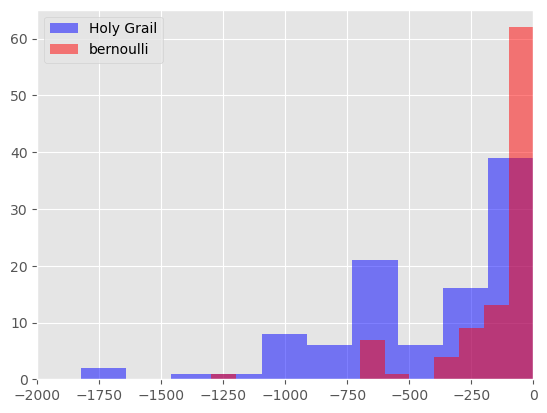

In [173]:
plt.style.use('ggplot')

bin_sizing_b = range(min(df_bernoulli['low_amount']),max(df_bernoulli['low_amount'])+100,100)
bin_sizing_h = range(min(df_holy_grail['low_amount']),max(df_holy_grail['low_amount'])+100,100)
plt.hist(df_holy_grail['low_amount'], alpha = 0.5, color = 'blue', label = 'Holy Grail')
plt.hist(df_bernoulli['low_amount'], alpha = 0.5, color = 'red', label = 'bernoulli', bins = bin_sizing_b)

plt.legend(loc = 'upper left')
plt.xlim([-2000,0])

plt.show()